# RGB-D Fusion

This exercise will describe how to fuse images from known poses into one pointcloud.

Note: if the interactive viewer does not work you may have to restart the notebook with `%matplotlib widget` instead of `%matplotlib notebook`

Note: Start a local jupyter notebook server in the command line via` jupter notebook --port xxxx`. Use the vs-code pop up to open jupyter in your local server.

Note: we use [Open3D](http://www.open3d.org/) for this exercise. Unfortunately the visualization requires OpenGL, which fails for setups like ours, where the visualization and the code run on separate machines. A minimal working solution (with drawbacks in quality) is to start a jupyter notebook on one of the pool machines (not the login) and use vscode for port-forwarding it to your local browser.
**The recommended way is to run everything on your local machine**

## Setup

1. Install requirements.txt with pip into your conda environment.
2. Download and extract data (if not running on the pool). Update the variable DATA_PATH below as appropriate.

~~~bash
# Download the data required for this exercise (30Mb)
wget https://lmb.informatik.uni-freiburg.de/people/argusm/wd_40.tar
tar -xvf wd_40.tar
~~~


In [1]:
BASE_PATH = "wd_40"  # if downloaded to the same folder as the notebook
# BASE_PATH = "/project/cv-ws2223/shared-data1/dataset_wd_40" # if running on the pool

In [2]:
%matplotlib notebook
# %matplotlib widget
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
try:
    import open3d as o3d
    print("open3d loaded")
except ImportError:
    print("open3d not loaded")
    pass

log = logging.getLogger(__name__)
np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
open3d loaded


## 1. Load Recorded Images

This cell defines a data class that loads images and data from files.

In [3]:
import json
from PIL import Image

class ViewLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        assert os.path.isdir(base_path)
        files = sorted(os.listdir(self.base_path))
        files = [f for f in files if (f.startswith("rgb_") and f.endswith(".png"))]
        self.start_idx = 2  # image 0 doesnt exist, image 1 is faulty, start at 2
        self.max_idx = int(files[-1].replace("rgb_", "").replace(".png", ""))
        print(f"Loaded {self.max_idx+1} images.")
        
    def __len__(self):
        return self.max_idx + 1
    
    def __getitem__(self, idx):
        return self.get_rgbdp(idx)

    def get_info(self):
        info = {
            "camera": {"calibration": 
            {"width": 640, "height": 480,
            "fx": 617.8902587890625, "fy": 617.8903198242188,
            "ppx": 315.20367431640625, "ppy": 245.70614624023438}}
        }
        return info
    
    def get_intrinsics(self):
        info = self.get_info()
        calib = info["camera"]["calibration"]
        return calib
    
    def get_K(self):
        calib = self.get_intrinsics()
        cam_intrinsic = np.eye(3)
        cam_intrinsic[0, 0] = calib["fx"]
        cam_intrinsic[1, 1] = calib["fy"]
        cam_intrinsic[0, 2] = calib["ppx"]
        cam_intrinsic[1, 2] = calib["ppy"]
        return cam_intrinsic
    
    def get_robot_pose(self, idx, return_dict=False):
        # 4x4 matrix position und drehung vom TCP (6 freiheitsgrade)
        pose_file = os.path.join(self.base_path, "pose_{0:04d}.json".format(idx) )
        with open(pose_file,"rb") as f_obj:
            pose = json.load(f_obj)
        pose_m = np.eye(4)
        pose_m[:3, :3] = R.from_euler("xyz", [pose[x] for x in ['rot_x', 'rot_y', 'rot_z']]).as_matrix()
        pose_m[:3, 3] = [pose[x] for x in ['x', 'y', 'z']]
        if return_dict:
            return pose_m, pose
        else:
            return pose_m
    
    def get_rgb_file(self, idx):
        rgb_file = os.path.join(self.base_path, "rgb_{0:04d}.png".format(idx) )
        return rgb_file
    
    def get_depth_file(self, idx):
        depth_file = os.path.join(self.base_path, "depth_{0:04d}.png".format(idx) )
        return depth_file    
    
    def get_rgbdp(self, idx):
        rgb_file = self.get_rgb_file(idx)
        depth_file = self.get_depth_file(idx)
        pose_m, pose_d = self.get_robot_pose(idx, True)
        # depth
        depth_scaling = pose_d["depth_scaling"]
        rgb  = np.asarray(Image.open(rgb_file))
        depth = np.asarray(Image.open(depth_file), dtype=np.float32) * depth_scaling
        return rgb, depth, pose_m
        
    def get_cam_pose(self, idx, marker_dir="pose_marker_one"):
        marker_dir = os.path.join(self.base_path, marker_dir)
        fn  = "{0:08d}.json".format(idx)
        pose_fn = os.path.join(marker_dir, fn)
        with open(pose_fn, "r") as fo:
            T = np.array(json.load(fo))
        return T
    
    def get_projection_matrix(self):
        # returns a 4x3 projection matrix using the intrinsics
        intr = self.get_intrinsics()
        cam_mat = np.array([[intr['fx'], 0, intr['ppx'], 0],
                            [0, intr['fy'], intr['ppy'], 0],
                            [0, 0, 1, 0]])
        assert cam_mat.shape == (3, 4)
        return cam_mat
    

    def project(self, X):
        """
        Project an (homogenous) cartesian coordinate into the camera frame.
        """
        assert X.shape == (4,), "Expects input as np.array([x, y, z, 1])"
        
        # project input to homogenous 2D coordinates given the camera projection matrix
        x = self.get_projection_matrix() @ X
        
        # convert homogenous 2D to euclidean 2D and round to integer pixels
        result = np.round(x[0:2] / x[2]).astype(int)
        
        # check if the output is a valid point in the image
        width, height = self.get_intrinsics()['width'], self.get_intrinsics()['height']
        if not (0 <= result[0] < width and 0 <= result[1] < height):
            log.warning("Projected point outside of image bounds")

        return result[0], result[1]

vl = ViewLoader(base_path=BASE_PATH)
print("camera calibration:")
camera_calibration = vl.get_K()
K = np.array(camera_calibration)
print(K.round(2))


Loaded 51 images.
camera calibration:
[[617.89   0.   315.2 ]
 [  0.   617.89 245.71]
 [  0.     0.     1.  ]]


Display loaded RGB images and corresponding depth maps.

<IPython.core.display.Javascript object>


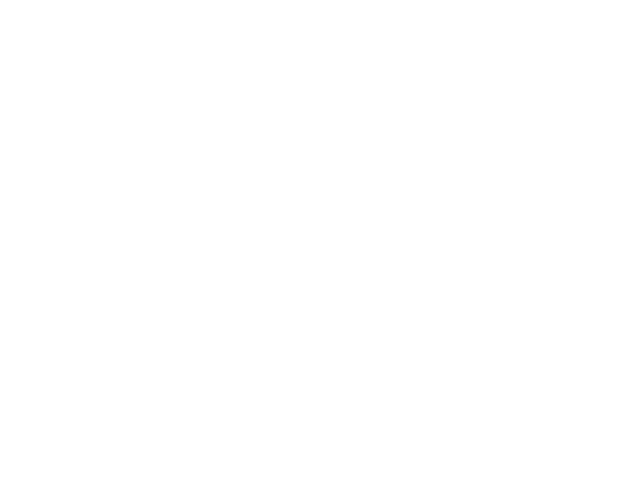

interactive(children=(IntSlider(value=2, description='w', layout=Layout(width='70%'), max=49, min=2), Output()…

In [4]:
from ipywidgets import widgets, Layout, interact

fig, ax = plt.subplots(1)
ax.set_title("RGB")
ax.set_axis_off()

line = None
def update(w):
    global line
    image, depth, pose = vl.get_rgbdp(w)
    if line is None:
        line = ax.imshow(np.asarray(image))
    else:
        line.set_data(np.asarray(image))
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=vl.start_idx, max=vl.max_idx-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)
pass

<IPython.core.display.Javascript object>


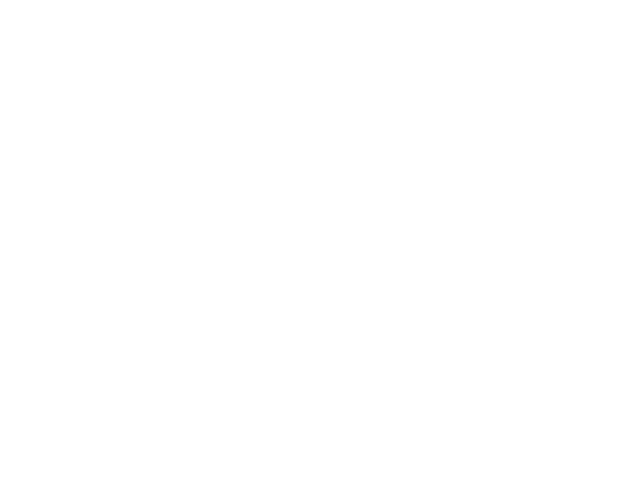

interactive(children=(IntSlider(value=2, description='w', layout=Layout(width='70%'), max=49, min=2), Output()…

In [5]:
fig, ax = plt.subplots(1)
ax.set_title("Depth")
ax.set_axis_off()

line = None
def update(w):
    global line
    image, depth, pose = vl.get_rgbdp(w)
    depth_for_plot = np.asarray(depth)
    if line is None:
        line = ax.imshow(depth_for_plot)
    else:
        line.set_data(depth_for_plot)
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=vl.start_idx, max=vl.max_idx-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)
pass

# 2. Show Marker Detection Results.

To simplify things marker detection has already been run. Next we want to verify its results.
Draw a coordinate frame into each image for which we have detection results.
The coordinate frame should have axis lengths of 10cm, with x=red, y=green, and z=blue.
This can be done using `PIL.ImageDraw`:

~~~python
im = Image.fromarray(numpy_image)
draw = ImageDraw.Draw(im)
draw.line((x1, y1, x2, y2), fill="red", width=5)
~~~

<IPython.core.display.Javascript object>


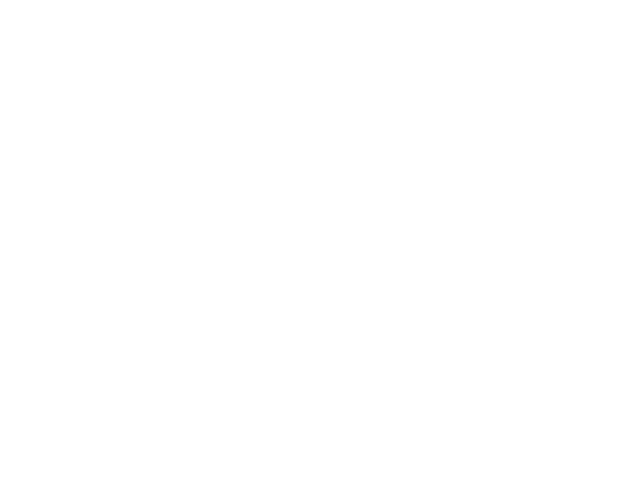

interactive(children=(IntSlider(value=2, description='w', layout=Layout(width='70%'), max=50, min=2), Output()…

In [6]:
from PIL import ImageDraw

def show_marker_pose(image, T_cam_object):
    """
    draw the coordinate frame into each image for which we have detection results
    
    Arguments:
        image: image as numpy.ndarray
        T_cam_object: transformation matrix from object to camera space, shape (4, 4)
            x_cam = T_cam_object @ x
        
    Returns:
        im: image as numpy.ndarray with coordinate frame drawn on it
    """
    # first we define our points in object space
    # we want to draw 3 lines going from the center into x, y and z direction
    dist = 0.1
    c = np.array([0, 0, 0, 1])
    x = np.array([dist, 0, 0, 1])
    y = np.array([0, dist, 0, 1])
    z = np.array([0, 0, dist, 1])
    
    # START TODO
    # 1. transform the above points from object to camera space
    # 2. project the points from camera to image space using vl.project
    # 3. draw the 3 lines using pillow as described above
    c_cam = T_cam_object @ c
    x_cam = T_cam_object @ x
    y_cam = T_cam_object @ y
    z_cam = T_cam_object @ z

    c_cam_x, c_cam_y = vl.project(c_cam)
    x_cam_x, x_cam_y = vl.project(x_cam)
    y_cam_x, y_cam_y = vl.project(y_cam)
    z_cam_x, z_cam_y = vl.project(z_cam)

    im = Image.fromarray(image)
    draw = ImageDraw.Draw(im)
    draw.line((c_cam_x, c_cam_y, x_cam_x, x_cam_y), fill="red", width=5)
    draw.line((c_cam_x, c_cam_y, y_cam_x, y_cam_y), fill="green", width=5)
    draw.line((c_cam_x, c_cam_y, z_cam_x, z_cam_y), fill="blue", width=5)
    # END TODO
    
    # convert image back to numpy
    return np.asarray(im)

line = None

def update(w):
    global line
    image, depth, pose = vl.get_rgbdp(w)
    try:
        T_cam_object = vl.get_cam_pose(w)
    except FileNotFoundError:
        print("No pose estimation.")
        line.set_data(image)
        return
    image_m = show_marker_pose(image, T_cam_object)
    
    if line is None:
        line = ax.imshow(image_m)
    else:
        line.set_data(image_m)
    fig.canvas.draw_idle()
    

fig, ax = plt.subplots(1)
ax.set_axis_off()
update(2)

slider_w = widgets.IntSlider(min=2, max=len(vl)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)
pass

## 3. Display Merged Pointclouds

In [7]:
%matplotlib inline
import open3d as o3d

# create camera intrinsics
first_rgb = Image.open(vl.get_rgb_file(vl.start_idx))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[1], first_rgb.size[0],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])

pcd_list = []
for i in range(vl.start_idx, vl.max_idx):
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
    
    # create the pointcloud given RGB and depth
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(np.array(depth_file).astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb, depth, depth_scale=1.0/depth_scaling, depth_trunc=1.0,
        convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
    
    # transform the pointcloud from camera space to object space, so that
    # all pointclouds use the same coordinate system
    T_est = np.linalg.inv(T_c)
    pcd.transform(T_est)
    
    pcd_list.append(pcd)

# merge pointclouds for easier visualization
pcd_all = pcd_list[0]
for pcd_cur in pcd_list[1:]:
    pcd_all += pcd_cur
o3d.visualization.draw_geometries([pcd_all], window_name='Merged pointcloud')


[Errno 2] No such file or directory: 'wd_40/pose_marker_one/00000003.json'
[Errno 2] No such file or directory: 'wd_40/pose_marker_one/00000034.json'
[Errno 2] No such file or directory: 'wd_40/pose_marker_one/00000045.json'


## 4. improve the pointcloud
- remove the gripper
- unify the points on the surface
- extract a mesh
- crop the mesh to show only the object

Just try out many things. You can find some inspiration in [tutorials](http://www.open3d.org/docs/0.8.0/index.html#tutorial-index). Make sure the docs version and your installed version match, since some functionality has changed.

### 4.1 remove the gripper

median: 0.3475000262260437


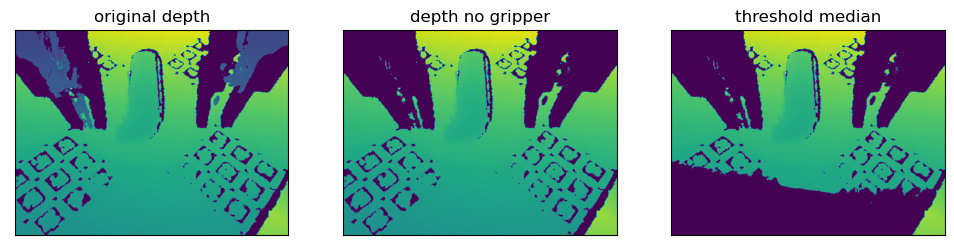

In [8]:
# use the depth values to create a mask for the gripper
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
image, depth, pose = vl.get_rgbdp(10)
ax = axes[0]
ax.imshow(depth)
ax.set_title('original depth')
# plt.show()

# find a depth threshold that works across images

# example: 0.25 (works ok)
depth_new = depth.copy()
depth_new[depth < 0.25] = 0
ax = axes[1]
ax.set_title("depth no gripper")
ax.imshow(depth_new)

# example: median of the image (removes too much)
depth_median = depth.copy()
median = np.median(depth_median)
print(f"median: {median}")
depth_median[depth_median < median] = 0
ax = axes[2]
ax.set_title("threshold median")
ax.imshow(depth_median)

# remove tick labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [9]:
# create a new pointcloud, removing all points with depth < depth_mask by setting their depth to 0
# if done correctly, the gripper should be removed
depth_mask = 0.25

def mask_depth(raw_depth, scaled_depth):
    raw_depth = np.array(raw_depth)
    # START TODO
    # 1. create a mask given the scaled depth and the threshold
    # 2. set the raw_depth to 0 for all masked points.
    # this way, they will be behind the camera and hidden
    mask = scaled_depth < depth_mask
    raw_depth[mask] = 0
    # END TODO
    return raw_depth

first_rgb = Image.open(vl.get_rgb_file(2))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[0], first_rgb.size[1],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])

pcd_list = []
for i in range(2, len(vl)):
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
        
        # get scaled depth and use it to mask the raw depth data in depth_file
        _, scaled_depth_, _ = vl.get_rgbdp(i)
        depth_file = mask_depth(depth_file, scaled_depth_)
    except (FileNotFoundError, ValueError):
        continue
    
    # create and transform pointcloud as before    
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(depth_file.astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
    T_est = np.linalg.inv(T_c)
    pcd.transform(T_est)
    pcd_list.append(pcd)

pcd_all = pcd_list[0]
for pcd_cur in pcd_list[1:]:
    pcd_all += pcd_cur
o3d.visualization.draw_geometries([pcd_all], window_name='Gripper removed')

### 4.2 remove outliers

In [10]:
# START TODO
# Select only every 5th point by using uniform_down_sample
uni_down_pcd = pcd_all.uniform_down_sample(every_k_points = 5)
# END TODO
o3d.visualization.draw_geometries([uni_down_pcd], window_name='Uniform point downsample')

In [11]:
# remove outliers
# Note: tested for open3d.__version__ == 0.8.0
#       open3d refactored this syntax between different versions
#       make sure to select the correct version in the docs
#       http://www.open3d.org/docs/0.8.0/
def display_inlier_outlier(cloud, ind):
    # v0.8
    # inlier_cloud = cloud.select_down_sample(ind)
    # outlier_cloud = cloud.select_down_sample(ind, invert=True)
    # v0.12
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], 
                                      window_name="Red outliers, gray inliers")

# START TODO
# Downsample the point cloud with a voxel of 0.002 using voxel_down_sample
voxel_down_pcd = pcd_all.voxel_down_sample(voxel_size = 0.002)
# END TODO
o3d.visualization.draw_geometries([voxel_down_pcd], window_name='Voxel downsample')

# START TODO
# Remove statistical outliers with remove_statistical_outlier on the voxel downsampled cloud
no_outlier_pcd, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.1)
# END TODO
o3d.visualization.draw_geometries([no_outlier_pcd], window_name='Remove_statistical_outlier')

# show which points where detected as outliers
display_inlier_outlier(voxel_down_pcd, ind)

# # This runs for a very long time
# # print("Radius oulier removal")
# cl,ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.1)
# o3d.visualization.draw_geometries([cl], window_name='Remove_statistical_outlier')
# display_inlier_outlier(voxel_down_pcd, ind)

Showing outliers (red) and inliers (gray): 


### 4.3 extract a mesh

In [12]:
print(pcd_all.get_min_bound())
print(pcd_all.get_max_bound())

# create the volume for the mesh

# - o3d v0.8
# volume = o3d.integration.ScalableTSDFVolume(
#     voxel_length=1.0 / 512.0,
#     sdf_trunc=0.10,
#     color_type=o3d.integration.TSDFVolumeColorType.RGB8)
# - o3d v0.12
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=1.0 / 512.0,
    sdf_trunc=0.10,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

first_rgb = Image.open(vl.get_rgb_file(2))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[0], first_rgb.size[1],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])
for i in range(2, len(vl)):
    if i % 10 == 0:
        print("Integrate {:d}-th image into the volume.".format(i))
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
        depth_file = np.array(depth_file)
        # get scaled depth and use it to mask the raw depth data in depth_file
        _, scaled_depth_, _ = vl.get_rgbdp(i)
        depth_file = mask_depth(depth_file, scaled_depth_)
    except (FileNotFoundError, ValueError):
        continue
    
    # create the pointcloud as before
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(depth_file.astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    
    # START TODO
    # use volume.integrate to integrate the pointcloud into the mesh
    volume.integrate(
        rgbd, 
        K_o3d,
        T_c
    )
    # END TODO

print("Extract a triangle mesh from the volume and visualize it.")
print(volume.extract_voxel_point_cloud())

mesh = volume.extract_triangle_mesh()
pcd_volume = volume.extract_point_cloud()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([pcd_volume], window_name='Pointcloud from volume')
o3d.visualization.draw_geometries([mesh], window_name='Mesh from volume')

[-0.55857027 -0.3139832  -0.24581634]
[0.19466689 0.54391116 0.14298662]
Integrate 10-th image into the volume.
Integrate 20-th image into the volume.
Integrate 30-th image into the volume.
Integrate 40-th image into the volume.
Integrate 50-th image into the volume.
Extract a triangle mesh from the volume and visualize it.
PointCloud with 8077336 points.


### 4.4 crop the mesh

In [13]:
# crop the mesh
print(mesh.get_min_bound())
print(mesh.get_max_bound())
# START TODO
# to create a bounding box, define center (3d vector), angle (scalar, radians) and size (3d vector)
box_center = [-0.125, 0.035, 0.03]
angle = -40/180. * np.pi
box_size = [0.1, 0.2, 0.07]
# END TODO

# create the bounding box given the parameters
obb = o3d.geometry.OrientedBoundingBox(
    np.array(box_center),  
    np.array([[np.cos(angle),-np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]]), # rotations
    np.array(box_size)
)

o3d.visualization.draw_geometries([mesh, obb], window_name='Mesh and bounding box')

cropped_mesh = mesh.crop(obb)
o3d.visualization.draw_geometries([cropped_mesh], window_name='Cropped mesh')


[-0.55371094 -0.29003906 -0.2451259 ]
[0.17768009 0.54003906 0.07542675]
